<a href="https://colab.research.google.com/github/satyasundar/erav3-s17/blob/main/stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
43

43

In [3]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae%2Fconfig.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [5]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images



In [6]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return error

<ipython-input-7-0bb0d8f6a082>:29: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 181.9796600341797
10 loss: 38.10272979736328
20 loss: 27.412736892700195


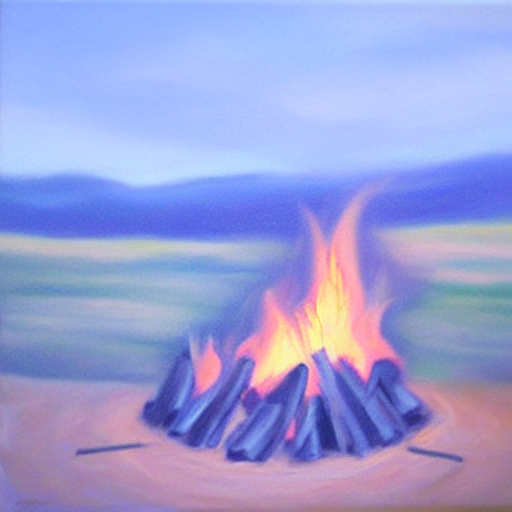

In [7]:
prompt = 'A campfire (oil on canvas)' #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30  #@param           # Number of denoising steps
guidance_scale = 8 #@param               # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #@param

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        latents_x0 = latents - sigma * noise_pred
        # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = blue_loss(denoised_images) * blue_loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

In [8]:
from transformers import CLIPTextModel, CLIPTokenizer, logging
from transformers import CLIPProcessor, CLIPModel  # Add these imports
import os

torch.manual_seed(1)

unet = unet.to(torch_device);

# Initialize CLIP model for similarity loss
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(torch_device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

def car_clip_loss(images):
    # images are already in range (0,1) from the denoised_images calculation

    # Process images to match CLIP's expected format
    images = torch.nn.functional.interpolate(images, size=(224, 224), mode='bicubic')

    # Normalize the images
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to(torch_device).reshape(1, 3, 1, 1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to(torch_device).reshape(1, 3, 1, 1)
    images = (images - mean) / std

    # Get image features directly using CLIP's vision model
    image_features = clip_model.get_image_features(images)

    # Get text features for car-related prompts
    text_inputs = tokenizer(
        ["a car", "a photograph of a car", "a vehicle"],
        padding=True,
        return_tensors="pt"
    ).to(torch_device)

    text_features = clip_model.get_text_features(**text_inputs)

    # Normalize features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Calculate similarity
    similarity = torch.matmul(image_features, text_features.T).mean()

    # Return negative similarity (since we minimize loss)
    return -similarity


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

<ipython-input-10-99b3d08c41bc>:29: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

0 clip loss: -1.8754496574401855
10 clip loss: -1.8330215215682983
20 clip loss: -1.4246037006378174
30 clip loss: -1.3986482620239258
40 clip loss: -1.7105355262756348


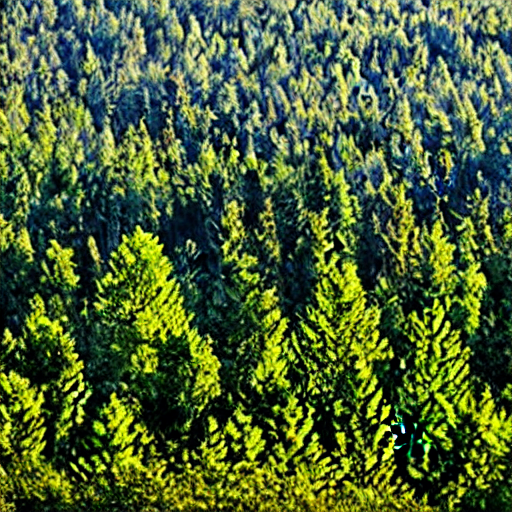

In [10]:
prompt = 'A forest landscape' #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 9 #@param               # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
clip_loss_scale = 10 #@param

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        latents_x0 = latents - sigma * noise_pred
        # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        #loss = blue_loss(denoised_images) * blue_loss_scale

        # Calculate loss using car CLIP similarity
        loss = car_clip_loss(denoised_images) * clip_loss_scale  # You might need to adjust the scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'clip loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]